In [170]:
import os
import re
import glob
from datetime import datetime
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
sys.path.append("..") # Adds higher directory to python modules path for importing from src dir

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from src.algorithms.simple.lstm import SimpleLSTM
from src.datasets import NyseStocksDataset, NyseSecuritiesDataset
from src.evaluation import Plotter
from src.pipeline import run_pipeline, prepare_data, evaluate_results

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 772 ms


In [2]:
sec_ds = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv')
sec_ds.data()

stocks_ds = NyseStocksDataset(file_path='../data/nyse/prices.csv')  # prices-split-adjusted
X_train, y_train, X_test, y_test = stocks_ds.data()


time: 11.3 s


In [3]:
plotter = Plotter('../reports')

time: 195 ms


## Run Pipeline

In [4]:
# stocks_ds = NyseStocksDataset(file_path='../data/nyse/prices.csv')
# X_train, y_train, X_test, y_test = stocks_ds.data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(*[f'{v}: {sum(y_train == v)}' for v in y_train.unique()])
print(*[f'{v}: {sum(y_test == v)}' for v in y_test.unique()])

(721646, 37) (721646,) (126111, 37) (126111,)
1.0: 266725 -1.0: 245211 0.0: 209710
1.0: 47281 -1.0: 41305 0.0: 37525
time: 384 ms


In [5]:
# stocks_ds = NyseStocksDataset(file_path='../data/nyse/prices.csv')
# X_train, y_train, X_test, y_test = stocks_ds.data()

# fit 60k: 600ms, 3min, 13min
# fit 300k: 1h40m, 36s, 1h13m
# fit 600k: ?

small_data = prepare_data(stocks_ds, 20000, 2000)
small_X_train, small_y_train, small_X_test, small_y_test = small_data

Train Labels --> -1.0: 20000; 0.0: 20000; 1.0: 20000
Training range: 2010-01-13 00:00:00 to 2010-10-01 00:00:00
Test Labels --> -1.0: 2000; 0.0: 2000; 1.0: 2000
Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
Done preparing data
time: 995 ms


In [11]:
predictor = SVC(verbose=True, gamma='scale')  # kernel='linear'
pipeline_svc, y_pred = run_pipeline(predictor, small_data, time_dim=False)
ev_svc = evaluate_results(small_data[3], y_pred)

[LibSVM]              precision    recall  f1-score   support

        Down       0.28      0.14      0.18      2000
       Still       0.37      0.53      0.44      2000
          Up       0.31      0.34      0.32      2000

   micro avg       0.33      0.33      0.33      6000
   macro avg       0.32      0.33      0.31      6000
weighted avg       0.32      0.33      0.31      6000

Precision=0.31930461132868
Recall=0.33266666666666667
F1-Score=0.3126841998928995
Accuracy=0.33266666666666667
MCC=-0.0010404274096390241
time: 7min 49s


In [13]:
predictor = MLPClassifier(activation='tanh',
    hidden_layer_sizes=(32, 32, 32, 3), max_iter=100,
    solver='adam', verbose=10, random_state=42)  # tol=1e-4, learning_rate_init=1e-4, alpha=0.0001
pipeline_mlp, y_pred = run_pipeline(predictor, small_data, time_dim=False)
ev_mlp = evaluate_results(small_data[3], y_pred)

Iteration 1, loss = 1.10548421
Iteration 2, loss = 1.09527870
Iteration 3, loss = 1.09401680
Iteration 4, loss = 1.09194390
Iteration 5, loss = 1.08993213
Iteration 6, loss = 1.08871687
Iteration 7, loss = 1.08778364
Iteration 8, loss = 1.08655321
Iteration 9, loss = 1.08528651
Iteration 10, loss = 1.08388225
Iteration 11, loss = 1.08224360
Iteration 12, loss = 1.08020557
Iteration 13, loss = 1.07924731
Iteration 14, loss = 1.07773276
Iteration 15, loss = 1.07766532
Iteration 16, loss = 1.07456821
Iteration 17, loss = 1.07486332
Iteration 18, loss = 1.07349334
Iteration 19, loss = 1.07311267
Iteration 20, loss = 1.07060003
Iteration 21, loss = 1.07049716
Iteration 22, loss = 1.07001303
Iteration 23, loss = 1.07038464
Iteration 24, loss = 1.06958092
Iteration 25, loss = 1.06787391
Iteration 26, loss = 1.06996117
Iteration 27, loss = 1.06797507
Iteration 28, loss = 1.06692242
Iteration 29, loss = 1.06704511
Iteration 30, loss = 1.06642374
Iteration 31, loss = 1.06519299
Iteration 32, los

c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

        Down       0.29      0.35      0.31      2000
       Still       0.35      0.42      0.38      2000
          Up       0.30      0.17      0.22      2000

   micro avg       0.32      0.32      0.32      6000
   macro avg       0.31      0.32      0.31      6000
weighted avg       0.31      0.32      0.31      6000

Precision=0.31274568386638857
Recall=0.31516666666666665
F1-Score=0.30655751144417637
Accuracy=0.31516666666666665
MCC=-0.027854506473725206
time: 38.9 s


In [139]:
X_test.iloc[0].index.

MultiIndex(levels=[['date', 'symbol', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7'], ['', 'C', 'H', 'L', 'O', 'V']],
           labels=[[0, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8], [0, 0, 4, 1, 3, 2, 5, 4, 1, 3, 2, 5, 4, 1, 3, 2, 5, 4, 1, 3, 2, 5, 4, 1, 3, 2, 5, 4, 1, 3, 2, 5, 4, 1, 3, 2, 5]],
           names=['day', 'feature'])

time: 241 ms


In [160]:
np.arange(7, 0, -1)

array([7, 6, 5, 4, 3, 2, 1])

time: 874 ms


In [178]:
def get_company_name(self, sym) -> str:
        securities = self.data()
        return securities[securities['Ticker symbol'] == sym].iloc[0]['Name']
NyseSecuritiesDataset.get_company_name = get_company_name

time: 224 ms


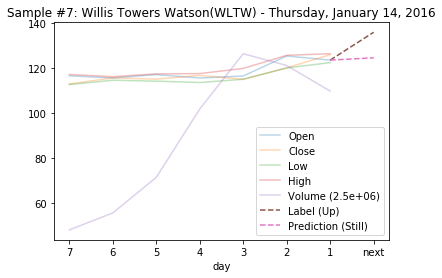

time: 456 ms


In [202]:
def translate_label(v):
    return 'Up' if v == 1 else 'Down' if v == -1 else 'Still'

def np_to_datetime(d64):
    timestamp = (d64 - np.datetime64(0, 's')) / np.timedelta64(1, 's')
    return datetime.utcfromtimestamp(timestamp)

def plot_sample(prediction, X, y):
    features = set(X.index.levels[1]) - set(('', ))
    n_timestamps = len(set(X.index.levels[0]) - set(('date', 'symbol')))
    ax = X[:, 'O'].plot(label='Open', alpha=0.3)
    if 'C' in features:
        X[:, 'C'].plot(label='Close', alpha=0.3)
    if 'L' in features:
        X[:, 'L'].plot(label='Low', alpha=0.3)
    if 'H' in features:
        X[:, 'H'].plot(label='High', alpha=0.3)
    if 'V' in features:
        v_max = X[:, 'V'].max()
        scalar = max([X[:, f].max() for f in features if f != 'V']) / v_max
        (X[:, 'V'] * scalar).plot(label=f'Volume ({v_max:.2n})', alpha=0.3)
    last_open = X[:, 'O'].iloc[n_timestamps - 1]
    filler = [None]*(n_timestamps - 1) + [last_open]
    plt.plot(filler + [last_open * (1 + y*0.1)], '--', label=f'Label ({translate_label(y)})')
    plt.plot(filler + [last_open + (1 + prediction*0.1)], '--', label=f'Prediction ({translate_label(prediction)})')
    ax.legend()
    ax.set_xticklabels([None] + list(np.arange(n_timestamps, 0, - 1)) + ['next'])
    date = np_to_datetime(X['date'].values[0])
    sym = X['symbol'].values[0]
    ax.set_title(f"Sample #{X.name}: {sec_ds.get_company_name('WLTW')}({sym}) - {date:%A, %B %d, %Y}")

plot_sample(y_pred[0], X_test.iloc[0], y_test.iloc[0])   # small_data[2].iloc[0] has no symol or date

In [75]:
# Optimize for batch_size (comp. time vs acc), shuffle vs no shuffle, 
predictor = SimpleLSTM(epochs=50, batch_size=32, n_units=[128])
pipeline_lstm, y_pred = run_pipeline(predictor, small_data)
ev_lstm = evaluate_results(small_data[3], y_pred)
# plotter.plot_history(predictor.history, store=False)

User Interaction: Stopped earlier!
              precision    recall  f1-score   support

        Down       0.33      0.41      0.36      2000
       Still       0.34      0.56      0.42      2000
          Up       0.28      0.02      0.04      2000

   micro avg       0.33      0.33      0.33      6000
   macro avg       0.31      0.33      0.28      6000
weighted avg       0.31      0.33      0.28      6000

Precision=0.31425948484772015
Recall=0.3313333333333333
F1-Score=0.2750275062548486
Accuracy=0.3313333333333333
MCC=-0.003411705172299551
time: 10.1 s


In [ ]:
evaluations = pd.DataFrame(dict([('SVC', ev_svc), ('MLP', ev_mlp), ('LSTM', ev_lstm)]),
                           index=['mcc', 'acc', 'f1', 'prec', 'rec'])
evaluations

In [ ]:
# evaluations.to_csv('../reports/Ev_svc_mlp_lstm_60k_6k.csv')
# evaluations.to_csv('../reports/Ev_svc_mlp_lstm_450k_45k.csv')

## Plot samples